<a href="https://colab.research.google.com/github/kang-jo/cv_model/blob/main/CNN_TF_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/datasetV3.zip -d /content/dataset/
# !rm -r /content/dataset

Archive:  /content/datasetV3.zip
   creating: /content/dataset/Gym Dataset Cropped/
   creating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/aug_204.jpg  
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/aug_202.jpg  
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/aug_200.jpg  
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/aug_203.jpg  
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/aug_198.jpg  
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/aug_194.jpg  
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/aug_195.jpg  
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/Image_35.png  
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/aug_196.jpg  
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/aug_197.jpg  
  inflating: /content/dataset/Gym Dataset Cropped/Lat Pulldown/aug_186.jpg  
  in

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

Num GPUs Available:  1


### iterate through the folders to create a dataframe of the form filepaths labels

In [2]:
sdir=r'./dataset/Gym Dataset Cropped'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths    labels
0  ./dataset/Gym Dataset Cropped/Dumbells/imageDu...  Dumbells
1  ./dataset/Gym Dataset Cropped/Dumbells/imageDu...  Dumbells
2  ./dataset/Gym Dataset Cropped/Dumbells/imageDu...  Dumbells
3  ./dataset/Gym Dataset Cropped/Dumbells/imageDu...  Dumbells
4  ./dataset/Gym Dataset Cropped/Dumbells/imageDu...  Dumbells
labels
Dumbells              200
KettleBell            200
Treadmill             200
Elliptical Machine    200
Recumbent Bike        200
Leg Press Machine     200
Bench Press           200
Swiss Ball            200
Dip Bar               200
Stair Climber         200
Lat Pulldown          200
PullBar               200
Name: count, dtype: int64


### split df into train_df, test_df and valid_df

In [3]:
train_split = 0.8
test_split = 0.1
dummy_split = test_split / (1 - train_split)

train_df, dummy_df = train_test_split(df, train_size=train_split, stratify=df['labels'], random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, stratify=dummy_df['labels'], random_state=123)

print('train_df length:', len(train_df), '  test_df length:', len(test_df), '  valid_df length:', len(valid_df))

train_df length: 1920   test_df length: 240   valid_df length: 240


In [4]:
print(test_df['labels'].unique())

['Leg Press Machine' 'Stair Climber' 'Treadmill' 'Dumbells' 'Swiss Ball'
 'Recumbent Bike' 'Elliptical Machine' 'PullBar' 'KettleBell'
 'Bench Press' 'Lat Pulldown' 'Dip Bar']


### create train, test, valid  generators

In [5]:
height=224
width=224
channels=3
batch_size=256

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  80   test steps:  3
Found 1920 validated image filenames belonging to 12 classes.
Found 240 validated image filenames belonging to 12 classes.
Found 240 validated image filenames belonging to 12 classes.
['Bench Press', 'Dip Bar', 'Dumbells', 'Elliptical Machine', 'KettleBell', 'Lat Pulldown', 'Leg Press Machine', 'PullBar', 'Recumbent Bike', 'Stair Climber', 'Swiss Ball', 'Treadmill']


### create function to show some image examples

In [6]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(15, 15))
    length=len(labels)
    if length<9:
        r=length
    else:
        r=9
    for i in range(r):
        plt.subplot(3, 3, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [7]:
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

In [8]:
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}


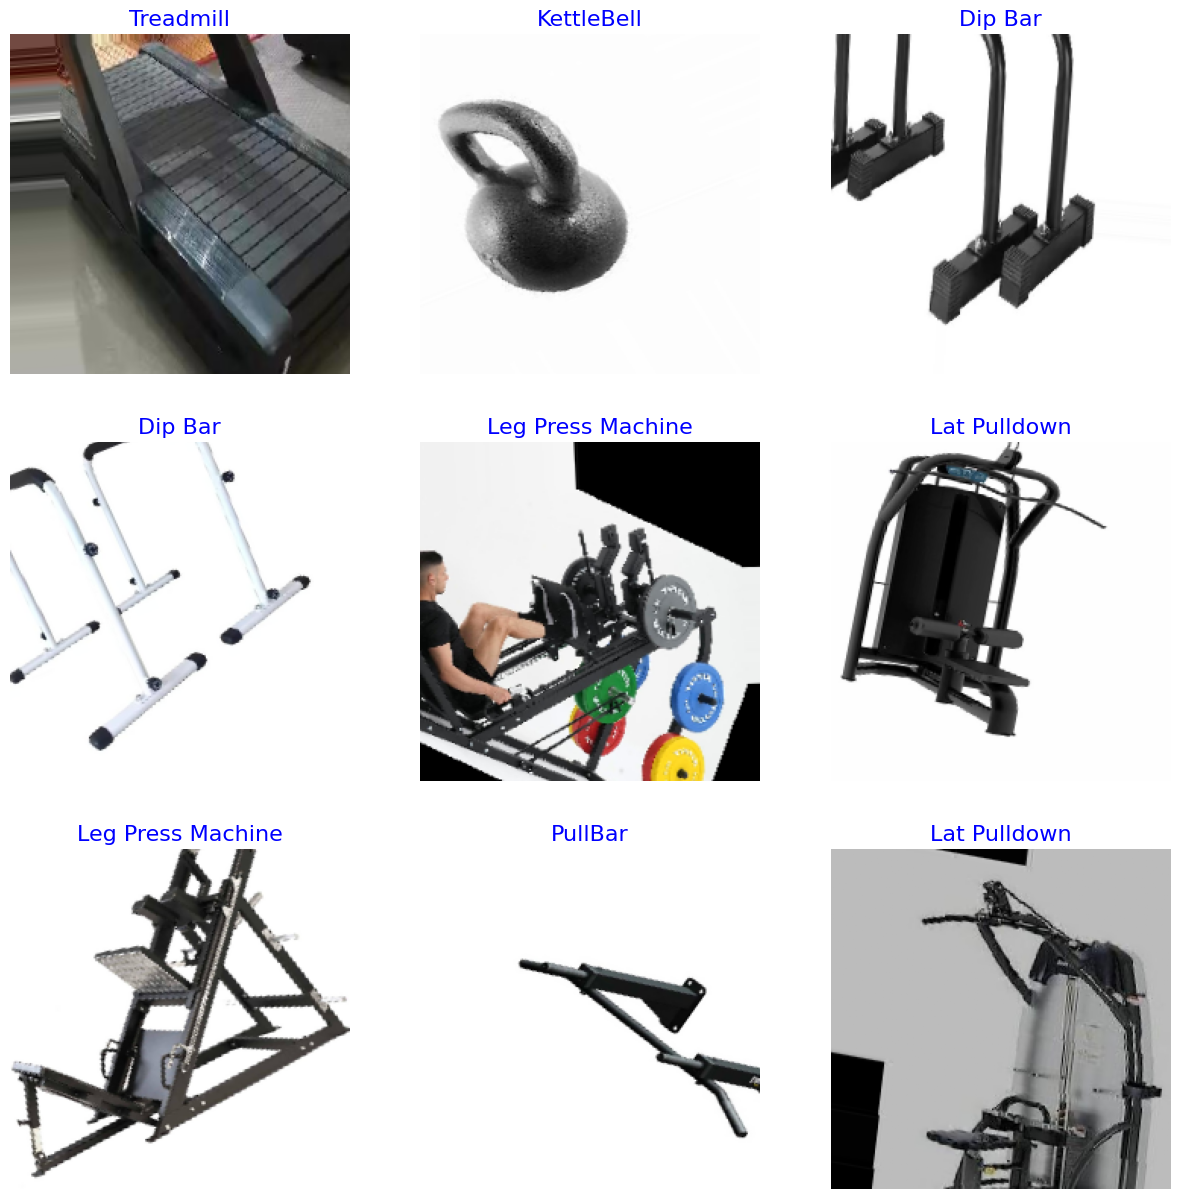

In [9]:
show_image_samples(train_gen)

### create the model

In [10]:
base_model=tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [12]:
base_model.trainable = False
# for layer in base_model.layers[:100]:  # Freeze lapisan awal
#     layer.trainable = False
# for layer in base_model.layers[-20:]:  # Unfreeze lapisan terakhir
#     layer.trainable = True

In [ ]:
# new_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [ ]:
# new_base.summary()

In [13]:
model_name='GymLens'
print("Building model with", base_model)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=(1, 1)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(class_count, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Building model with <Functional name=densenet121, built=True>


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 64)            │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           6,156 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,810,892 (29.80 MB)

 Trainable params: 773,132 (2.95 MB)

 Non-trainable params: 7,037,760 (26.85 MB)

In [ ]:
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nStopping training as validation accuracy reached {val_acc:.2f} (≥ {self.target_accuracy:.2f})")
            self.model.stop_training = True

early_stopping = EarlyStoppingAtAccuracy(target_accuracy=0.98)

In [15]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        verbose=1,
        restore_best_weights=True
    )
]

In [16]:
epochs = 100

history=model.fit(
    x=train_gen,
    batch_size=32,
    epochs=epochs,
    validation_data=valid_gen,
    # class_weight=class_weights,
    callbacks=[callbacks]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 162s 14s/step - accuracy: 0.1352 - loss: 2.5978 - precision: 0.1481 - recall: 2.6143e-04 - val_accuracy: 0.2208 - val_loss: 2.4630 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 744ms/step - accuracy: 0.1816 - loss: 2.3979 - precision: 0.8889 - recall: 0.0016 - val_accuracy: 0.3375 - val_loss: 2.3909 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 721ms/step - accuracy: 0.2729 - loss: 2.2007 - precision: 1.0000 - recall: 0.0108 - val_accuracy: 0.4708 - val_loss: 2.3083 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 712ms/step - accuracy: 0.3440 - loss: 2.0467 - precision: 1.0000 - recall: 0.0333 - val_accuracy: 0.5750 - val_loss: 2.2022 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/100
8/8 ━━━━━━━━━

### define function to print text in RGB foreground and background colors

In [17]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

### define function to plot the training data

In [18]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


### define function to generate the confusion matrix and classification report

In [19]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key

    classes=list(new_dict.values())
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count)
                plot_class.append(value)
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:

        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

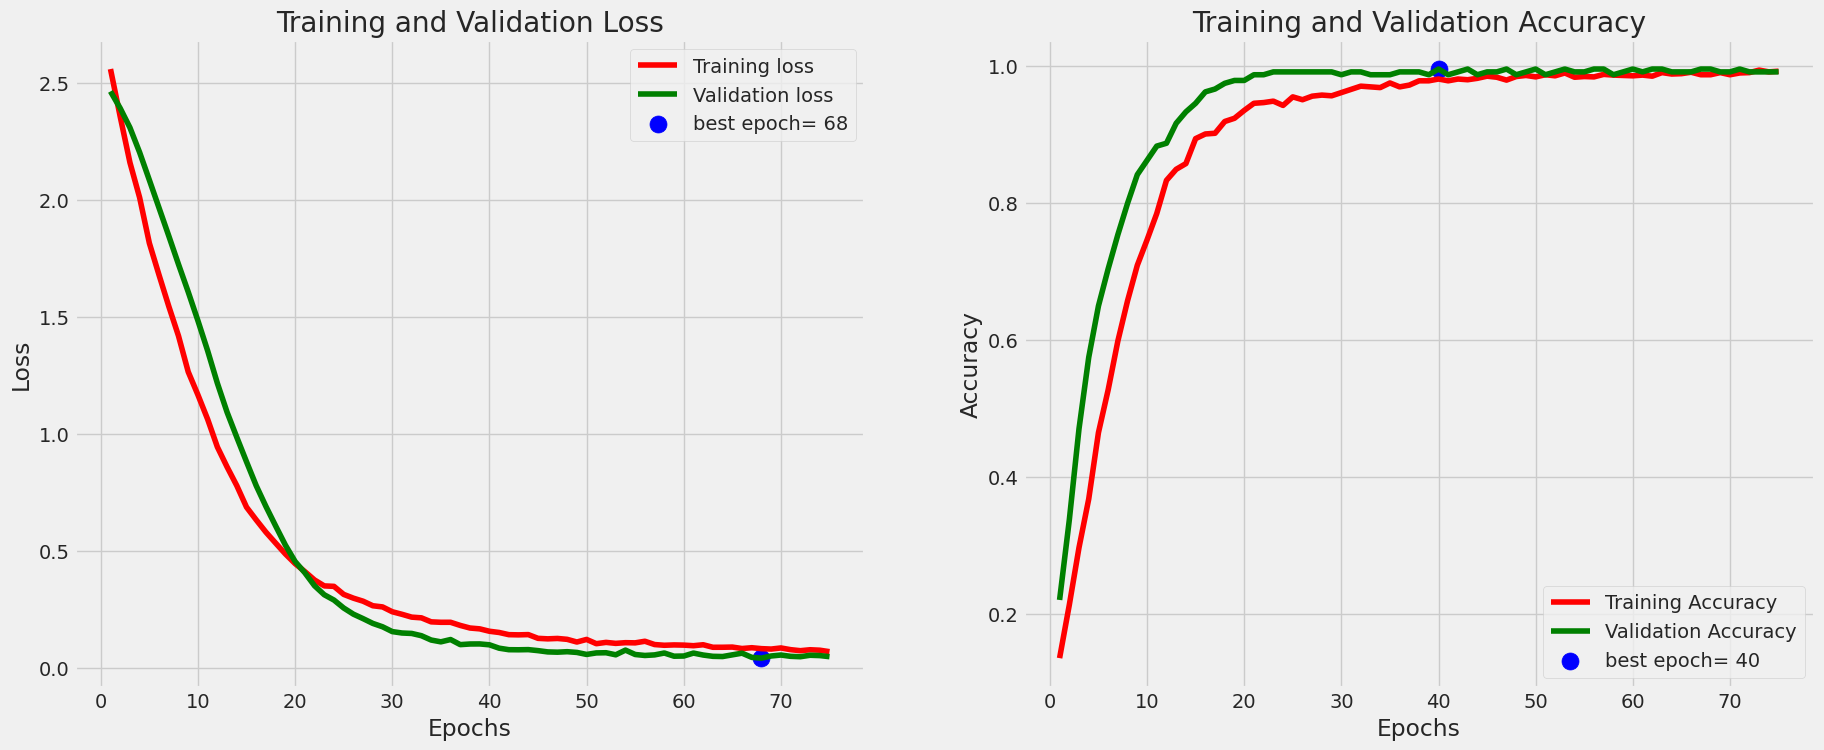

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - accuracy: 0.9979 - loss: 0.0368 - precision: 0.9979 - recall: 0.9979
accuracy on the test set is 99.58 %



In [20]:
tr_plot(history,0)
save_dir=r'./'
subject='Gym Exception'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')

### make predictions on test set and generate confusion matrix and classification report

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step


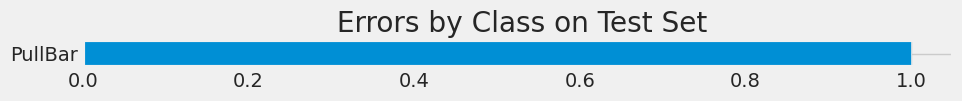

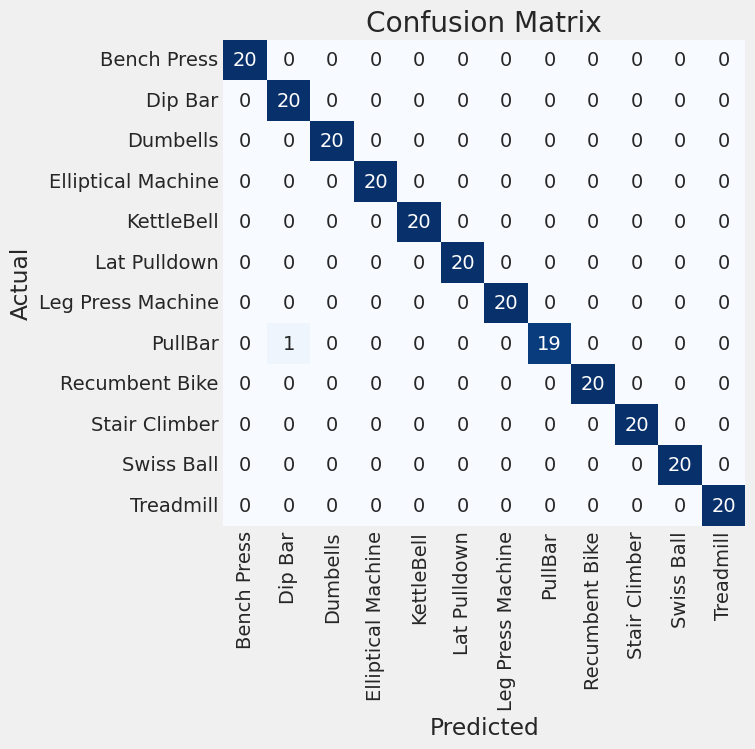

Classification Report:
----------------------
                     precision    recall  f1-score   support

       Bench Press       1.00      1.00      1.00        20
           Dip Bar       0.95      1.00      0.98        20
          Dumbells       1.00      1.00      1.00        20
Elliptical Machine       1.00      1.00      1.00        20
        KettleBell       1.00      1.00      1.00        20
      Lat Pulldown       1.00      1.00      1.00        20
 Leg Press Machine       1.00      1.00      1.00        20
           PullBar       1.00      0.95      0.97        20
    Recumbent Bike       1.00      1.00      1.00        20
     Stair Climber       1.00      1.00      1.00        20
        Swiss Ball       1.00      1.00      1.00        20
         Treadmill       1.00      1.00      1.00        20

          accuracy                           1.00       240
         macro avg       1.00      1.00      1.00       240
      weighted avg       1.00      1.00      1.00  

In [21]:
print_code=0
save_dir=r'./'
subject='Gym Exception'
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

In [22]:
def prepare_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

image_path = './dataset/tes/pullBar_92.jpg'
image_to_predict = prepare_image(image_path)

class_names = ['Bench Press', 'Dip Bar', 'Dumbells', 'Elliptical Machine', 'KettleBell', 'Lat Pulldown', 'Leg Press Machine', 'PullBar', 'Recumbent Bike', 'Stair Climber', 'Swiss Ball', 'Treadmill']

predictions = model.predict(image_to_predict)
predicted_class_index = np.argmax(predictions, axis=1)

if len(predicted_class_index) > 0:
    predicted_class_name = class_names[predicted_class_index[0]]
    print(f'Predicted class: {predicted_class_name}')
else:
    print("No predictions were made.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted class: PullBar


In [ ]:
# !rm -r /content/tes/.ipynb_checkpoints

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

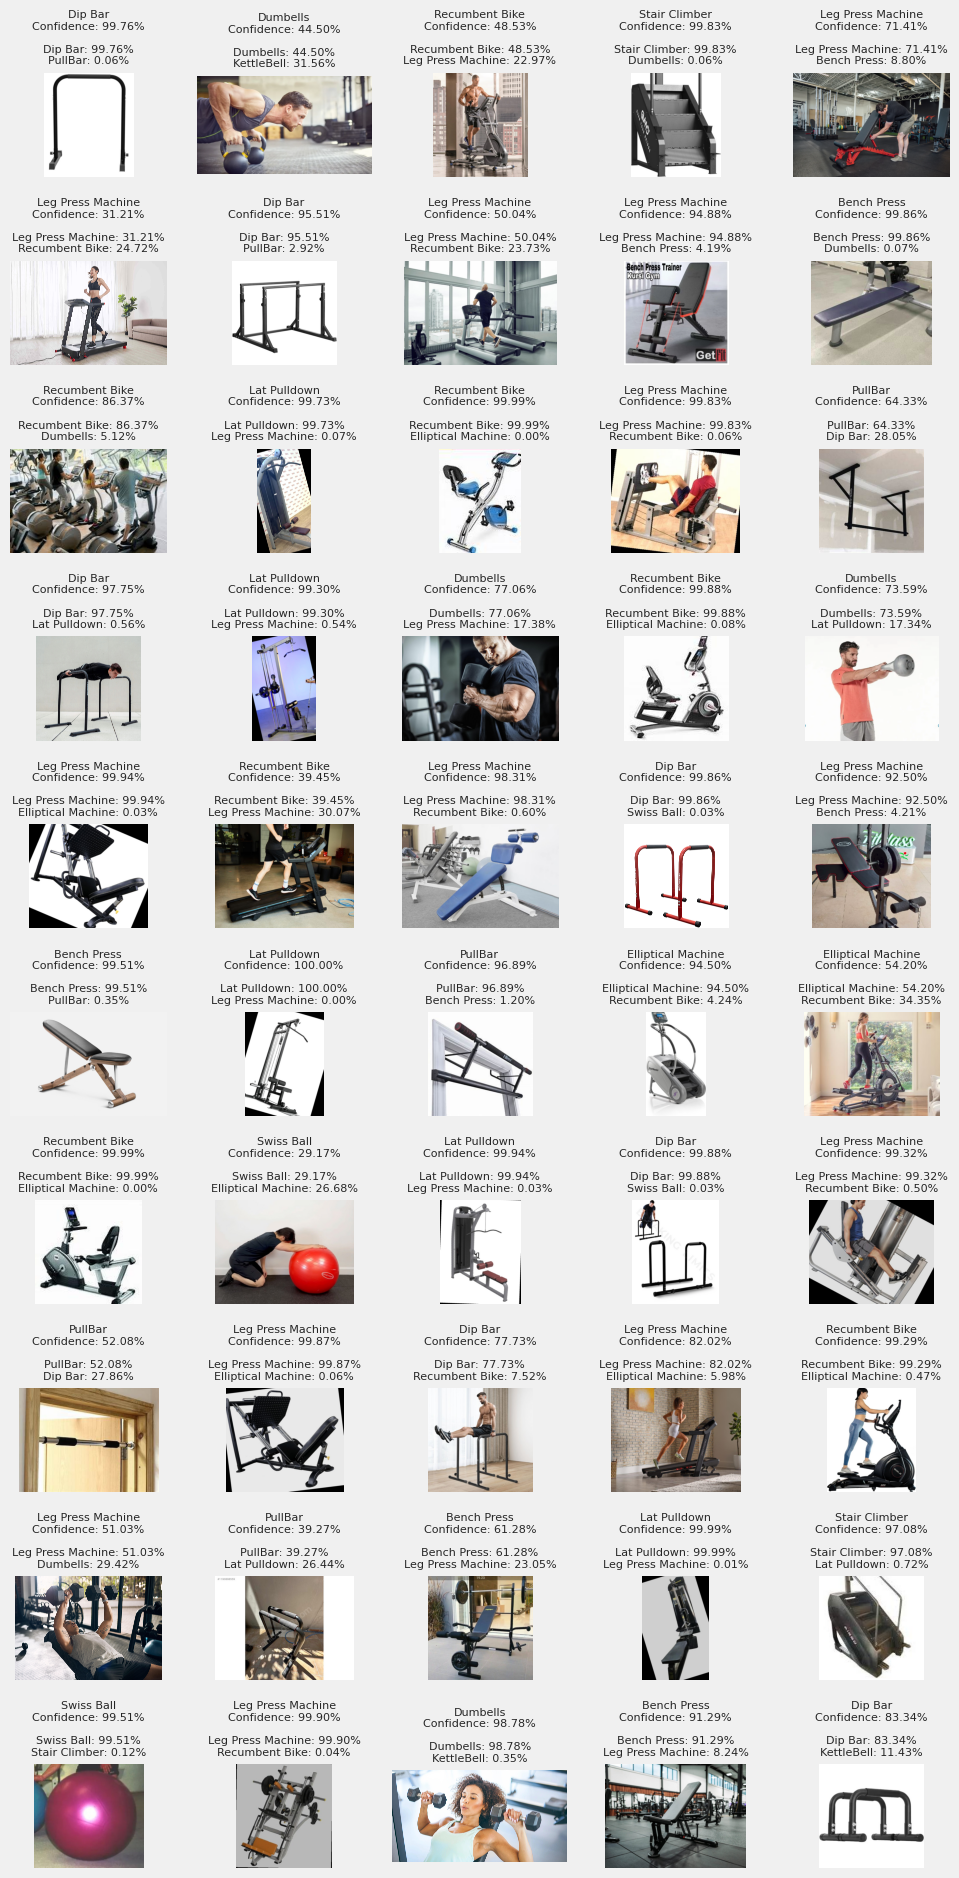

In [29]:
directory_path = './dataset/tes'
class_names = ['Bench Press', 'Dip Bar', 'Dumbells', 'Elliptical Machine', 'KettleBell', 'Lat Pulldown', 'Leg Press Machine', 'PullBar', 'Recumbent Bike', 'Stair Climber', 'Swiss Ball', 'Treadmill']
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(10, 19))
axes = axes.flatten()

for i, filename in enumerate(os.listdir(directory_path)):
    image_path = os.path.join(directory_path, filename)
    image = prepare_image(image_path)

    predictions = model.predict(image)
    predicted_class_index = np.argsort(predictions[0])[-2:][::-1]
    predicted_class_name = [class_names[idx] for idx in predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    img = tf.keras.preprocessing.image.load_img(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')


    confidence_text = "\n".join([f"{predicted_class_name[j]}: {confidence[j]:.2f}%" for j in range(2)])
    axes[i].set_title(f"{predicted_class_name[0]}\nConfidence: {confidence[0]:.2f}%\n\n{confidence_text}", fontsize=8)

    if i == 49:
        break

plt.tight_layout()
plt.show()


In [24]:
model.save('./gym_model_densenet121_9958.h5')

In [25]:
imp_model = load_model('./gym_model_densenet121_9958.h5')

# Evaluasi model
results = imp_model.evaluate(valid_gen)
print("Validation Results:", results)

# Prediksi
predictions = imp_model.predict(test_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.9958 - loss: 0.0411 - precision: 0.9958 - recall: 0.9958
Validation Results: [0.041115425527095795, 0.9958333373069763, 0.9958333373069763, 0.9958333373069763]
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step


In [ ]:
class_names = ['Bench Press', 'Dip Bar', 'Dumbells', 'Elliptical Machine', 'KettleBell', 'Lat Pulldown', 'Leg Press Machine', 'PullBar', 'Recumbent Bike', 'Stair Climber', 'Swiss Ball', 'Treadmill']

# Simpan ke file .pkl atau .json
import pickle
with open('/content/class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

In [ ]:
with open('/content/class_names.pkl', 'rb') as f:
    class_names = pickle.load(f)
print("Class Names:", class_names)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
!cp "/content/Gym Exception-12.txt" "/content/drive/MyDrive/Colab Notebooks"